## Load Data

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [3]:
df = pd.read_csv('../dataset/after_selection/train.csv')
df.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction,Response
0,1,46.0,1,0,0,152.0,0,0,0
1,1,46.0,1,0,0,152.0,0,0,0
2,1,46.0,1,1,1,26.0,2,2,0
3,1,18.0,1,0,0,152.0,1,0,0
4,1,11.0,0,1,1,122.0,2,2,0


## 1. Modeling

### Split Data Train & Test

In [4]:
X = df.drop(columns=['Response'])
y = df[['Response']]

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Algoritma Modeling

#### Test All Classifier

In [ ]:
# # Define a list of classifiers to try
# classifiers = [
#     LogisticRegression(),
#     KNeighborsClassifier(),
#     SVC(),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     GaussianNB(),
#     GradientBoostingClassifier(),
#     AdaBoostClassifier(),
#     XGBClassifier(),
#     CatBoostClassifier(),
# ]

# # Create an empty DataFrame to store results
# results_df = pd.DataFrame(columns=['Classifier', 'Accuracy'])

# # Train and evaluate each classifier
# for classifier in classifiers:
#     try:
#         # Train the classifier
#         classifier.fit(X_train, y_train)

#         # Make predictions on the test set
#         y_pred = classifier.predict(X_test)

#         # Evaluate the model performance
#         accuracy = accuracy_score(y_test, y_pred)

#         # Append results to the DataFrame
#         results_df = results_df.append({'Classifier': classifier.__class__.__name__, 'Accuracy': accuracy}, ignore_index=True)

#     except Exception as e:
#         # Handle exceptions
#         print(f"Error with {classifier.__class__.__name__}: {e}")

# results_df.to_csv('../dataset/results/classifier_accuracy.csv', index=False)

In [7]:
results_df = pd.read_csv('../dataset/results/classifier_accuracy.csv')
results_df.sort_values(by='Accuracy', ascending=False)

,Classifier,Accuracy
9,CatBoostClassifier,0.797309
8,XGBClassifier,0.797088
7,AdaBoostClassifier,0.795538
6,GradientBoostingClassifier,0.792493
4,RandomForestClassifier,0.792216
3,DecisionTreeClassifier,0.789946
5,GaussianNB,0.784022
0,LogisticRegression,0.783081
2,SVC,0.774167
1,KNeighborsClassifier,0.767135


#### XGBoost

In [29]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report

### Hyperparameter Tunning

In [30]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform('gamma', 1, 9),
         'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': 300,
         'seed': 0
         }

In [39]:
def objective(space):
    clf = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        min_child_weight=space['min_child_weight'],
        colsample_bytree=space['colsample_bytree'],
        eval_metric="logloss",  # Set eval_metric directly in the constructor
    )

    evaluation = [(X_train, y_train), (X_test, y_test)]

    clf.fit(
        X_train, y_train,
        eval_set=evaluation,
        early_stopping_rounds=10,  # Set early_stopping_rounds directly in the constructor
        verbose=False
    )

    pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, pred > 0.5)
    Roc_Auc_Score = roc_auc_score(y_test, y_score)
    print("ROC-AUC Score:", Roc_Auc_Score)
    print("SCORE:", accuracy)
    return {'loss': -Roc_Auc_Score, 'status': STATUS_OK}

In [40]:
trials = Trials()

In [ ]:
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

In [42]:
print("The best hyperparameters are : ", "\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7585211652976948, 'gamma': 1.1214617172564334, 'max_depth': 8.0, 'min_child_weight': 6.0, 'reg_alpha': 42.0, 'reg_lambda': 0.35789710237725963}


In [47]:
xgb_model = XGBClassifier(
    n_estimators=space['n_estimators'], 
    max_depth=8, 
    gamma=1.1214617172564334, 
    reg_lambda=0.35789710237725963,
    reg_alpha=42.0, 
    min_child_weight=6.0, 
    colsample_bytree=0.7585211652976948)

In [62]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7585211652976948, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.1214617172564334,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Model Evaluation

In [68]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def eval_classification(model, X, y, n_splits=5):
    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_results = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                                cv=cv, return_train_score=False)

    # Display cross-validation results
    print(f"Cross-Validation Results (Average over {n_splits} folds):")
    print(f"Accuracy: {cv_results['test_accuracy'].mean():.2f}")
    print(f"Precision: {cv_results['test_precision'].mean():.2f}")
    print(f"Recall: {cv_results['test_recall'].mean():.2f}")
    print(f"F1-Score: {cv_results['test_f1'].mean():.2f}")
    print(f"ROC-AUC: {cv_results['test_roc_auc'].mean():.2f}")

    # Train the model on the entire dataset
    model.fit(X, y)

    # Evaluate on the training set
    y_pred_train = model.predict(X)
    y_pred_proba_train = model.predict_proba(X)[:, 1]

    # Display metrics for the training set
    print("\nMetrics for the Entire Training Set:")
    print("Accuracy: %.2f" % accuracy_score(y, y_pred_train))
    print("Precision: %.2f" % precision_score(y, y_pred_train))
    print("Recall: %.2f" % recall_score(y, y_pred_train))
    print("F1-Score: %.2f" % f1_score(y, y_pred_train))
    print("ROC-AUC: %.2f" % roc_auc_score(y, y_pred_proba_train))

In [77]:
eval_classification(xgb_model, X, y)

Cross-Validation Results (Average over 5 folds):
Accuracy: 0.80
Precision: 0.73
Recall: 0.93
F1-Score: 0.82
ROC-AUC: 0.85

Metrics for the Entire Training Set:
Accuracy: 0.80
Precision: 0.73
Recall: 0.93
F1-Score: 0.82
ROC-AUC: 0.85


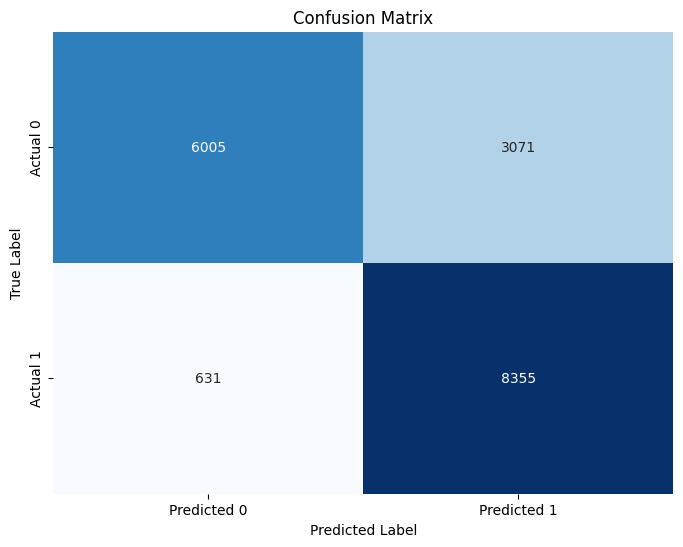

In [74]:
# Obtain the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [56]:
filename = './models/xgboost_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

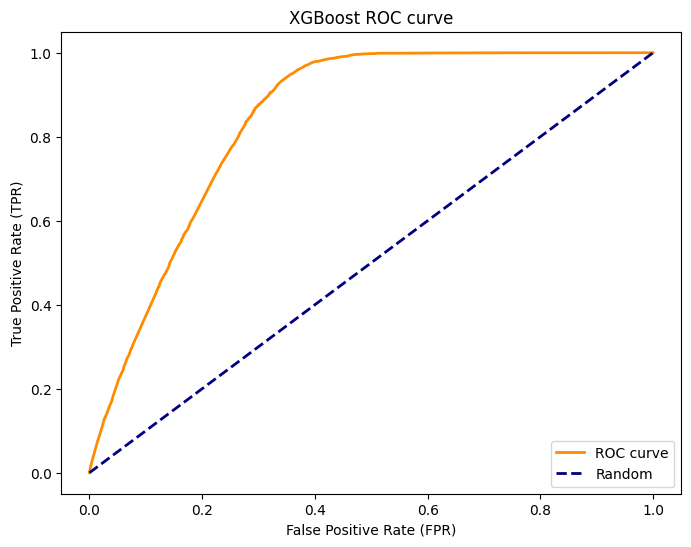

Area under curve (AUC): 0.8414060393342879


In [53]:
# Calculate ROC curve
y_score = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('XGBoost ROC curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and print AUC
roc_auc = auc(fpr, tpr)
print('Area under curve (AUC):', roc_auc)

## Feature Importance

                          Feature  Importance
1                     Region_Code    0.002399
0                 Driving_License    0.002600
3                     Vehicle_Age    0.002734
5            Policy_Sales_Channel    0.004338
7  Vehicle_Damage_Age_Interaction    0.024069
6                         Age_Bin    0.032968
2              Previously_Insured    0.313463
4                  Vehicle_Damage    0.617428


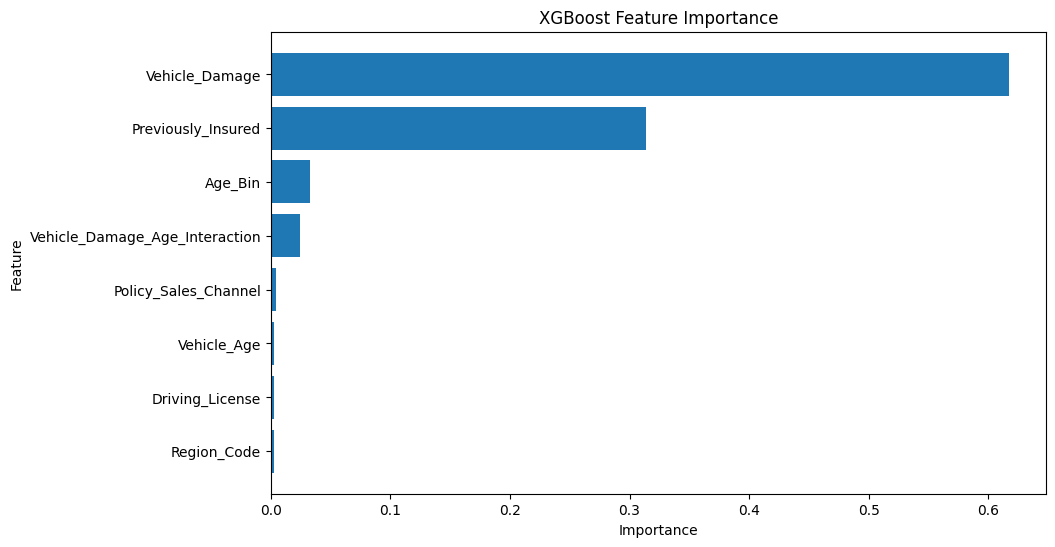

In [61]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get feature names (optional)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Print or plot the feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()